# This notebook demonstrates plotting various cell tracking statistics using the stats file

In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import shapely.geometry as sgeom
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline

In [2]:
# Specify cell track statistics data location
stats_file = '../06/stats/trackstats_20220601.0000_20220630.2359.nc'
# Terrain file is for plotting purpose only
terrain_file = './KHGX_Terrain_RangeMask.nc'


# Radar location
radar_lat = 29.4719
radar_lon = -95.0787

# Output figure directory
figdir = '../Figures'
os.makedirs(figdir, exist_ok=True)

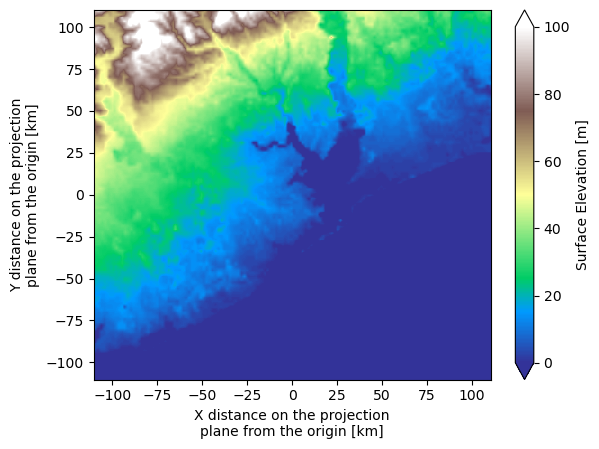

In [3]:
# Read topography file
terr = xr.open_dataset(terrain_file)
topoZ = terr['hgt']
topoLon = terr['x']
topoLat = terr['y']
topoZ.plot(vmin=0, vmax=100, cmap='terrain')

In [4]:
# Read cell tracking data
stats = xr.open_dataset(stats_file)
time_res = stats.attrs['time_resolution_hour']
pixel_radius = stats.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Find tracks where initiation longitude is not NaN
# These tracks are problematic and should be excluded
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
stats = stats.isel(tracks=ind).load()
ntracks = stats.dims['tracks']
print(f'Number of valid tracks: {ntracks}')
stats

c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\xarray\coding\times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


Number of valid tracks: 3606


<xarray.Dataset>
Dimensions:                  (tracks: 3606, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 3602 3603 3604 3605
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 3 18 15 2 9 6 2 ... 1 4 4 3 1 2 2
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 3.581e+03 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 11.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 5.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan ... 3.581e+03 nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... 13.0 nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... 10.0 nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

## Get cell statistics variables

In [5]:
tracks = stats['tracks']
times = stats['times']

lifetime = stats['track_duration'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
core_area = stats['core_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['max_dbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

## Get cell start/end location and status

In [6]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\matplotlib\axes\_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

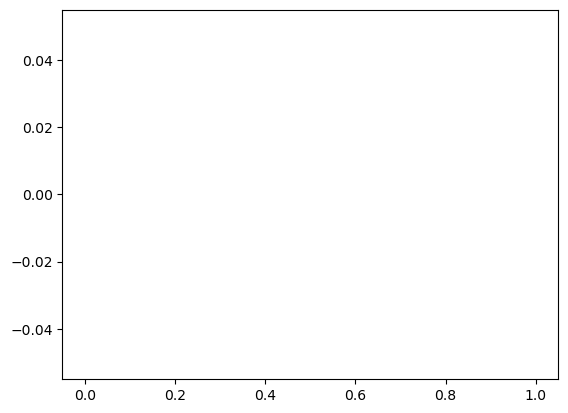

In [7]:
plt.hist(end_maxrange_flag, bins=np.arange(0,1.01,0.1))

## Find merge/split tracks

In [8]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 3076
Number of non-split tracks: 3086
Number of non-split tracks within max range: 0
Number of non-merge tracks within max range: 0
Number of merge tracks: 530
Number of split tracks: 520


## Count tracks by diurnal timing

In [9]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Initiation E.SDC vs. W.SDC
lon_SDC = -65
hist_starthour_eSDC, bins = np.histogram(start_hour.where(start_lon > lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)
hist_starthour_wSDC, bins = np.histogram(start_hour.where(start_lon <= lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

hist_starthour_eSDC_LT = np.roll(hist_starthour_eSDC, -3)
hist_starthour_wSDC_LT = np.roll(hist_starthour_wSDC, -3)

# Fraction of E.SDC tracks to all tracks
hist_starthour_eSDC_LT_frac = 100 * (hist_starthour_eSDC_LT / hist_starthour_LT)

## Plot cell counts by diurnal timing

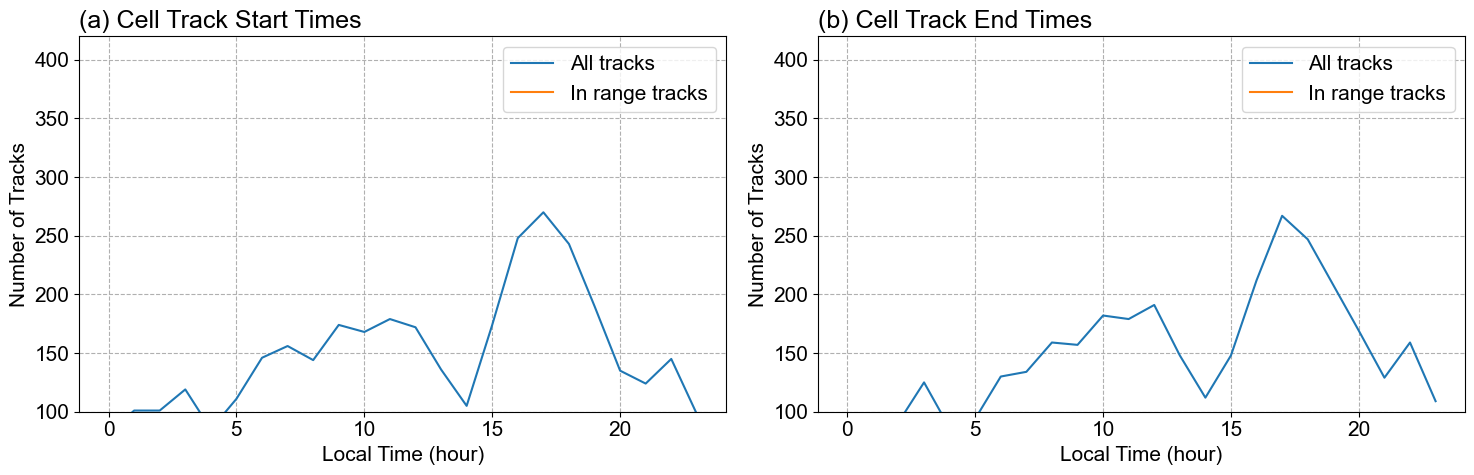

In [10]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'
fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

ax1 = axes[0]
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
ax1.legend()
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Start Times', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylim(100, 420)

ax2 = axes[1]
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
ax2.legend()
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track End Times', loc='left')
ax2.set_ylabel('Number of Tracks')
ax2.set_xlabel('Local Time (hour)')
ax2.set_ylim(100, 420)

fig.tight_layout()

## Get cell lifetime maximum values

In [11]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
cell_eth20_max = eth20.max(dim='times')
cell_maxdbz_max = maxdbz.max(dim='times')

## Bin cell lifetime maximum values by initiation hour for box plot

In [12]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_max_hourbin = []
cell_diam_max_hourbin = []
cell_eth20_max_hourbin = []
cell_maxdbz_max_hourbin = []
cell_minctt_min_hourbin = []
for ihour in range(24):
    cell_area_max_hourbin.append(np.log10(cell_area_max.where(start_hour == ihour, drop=True)).values)
    cell_diam_max_hourbin.append(cell_diam_max.where(start_hour == ihour, drop=True).values)
    cell_eth20_max_hourbin.append(cell_eth20_max.where((start_hour == ihour) & (~np.isnan(cell_eth20_max)), drop=True).values)
    cell_maxdbz_max_hourbin.append(cell_maxdbz_max.where((start_hour == ihour) & (~np.isnan(cell_maxdbz_max)), drop=True).values)
    # cell_minctt_min_hourbin.append(cell_minctt_min.where((start_hour == ihour) & (~np.isnan(cell_minctt_min)), drop=True).values)

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_max_hourbin = np.array(cell_diam_max_hourbin, dtype=object, copy=False, subok=True)
cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
cell_area_max_hourbin = np.array(cell_area_max_hourbin, dtype=object, copy=False, subok=True)
cell_area_max_hourbin_LT = np.roll(cell_area_max_hourbin, -3)
cell_eth20_max_hourbin = np.array(cell_eth20_max_hourbin, dtype=object, copy=False, subok=True)
cell_eth20_max_hourbin_LT = np.roll(cell_eth20_max_hourbin, -3)
cell_maxdbz_max_hourbin = np.array(cell_maxdbz_max_hourbin, dtype=object, copy=False, subok=True)
cell_maxdbz_max_hourbin_LT = np.roll(cell_maxdbz_max_hourbin, -3)

## Function to plot diurnal cycle of cell statistics

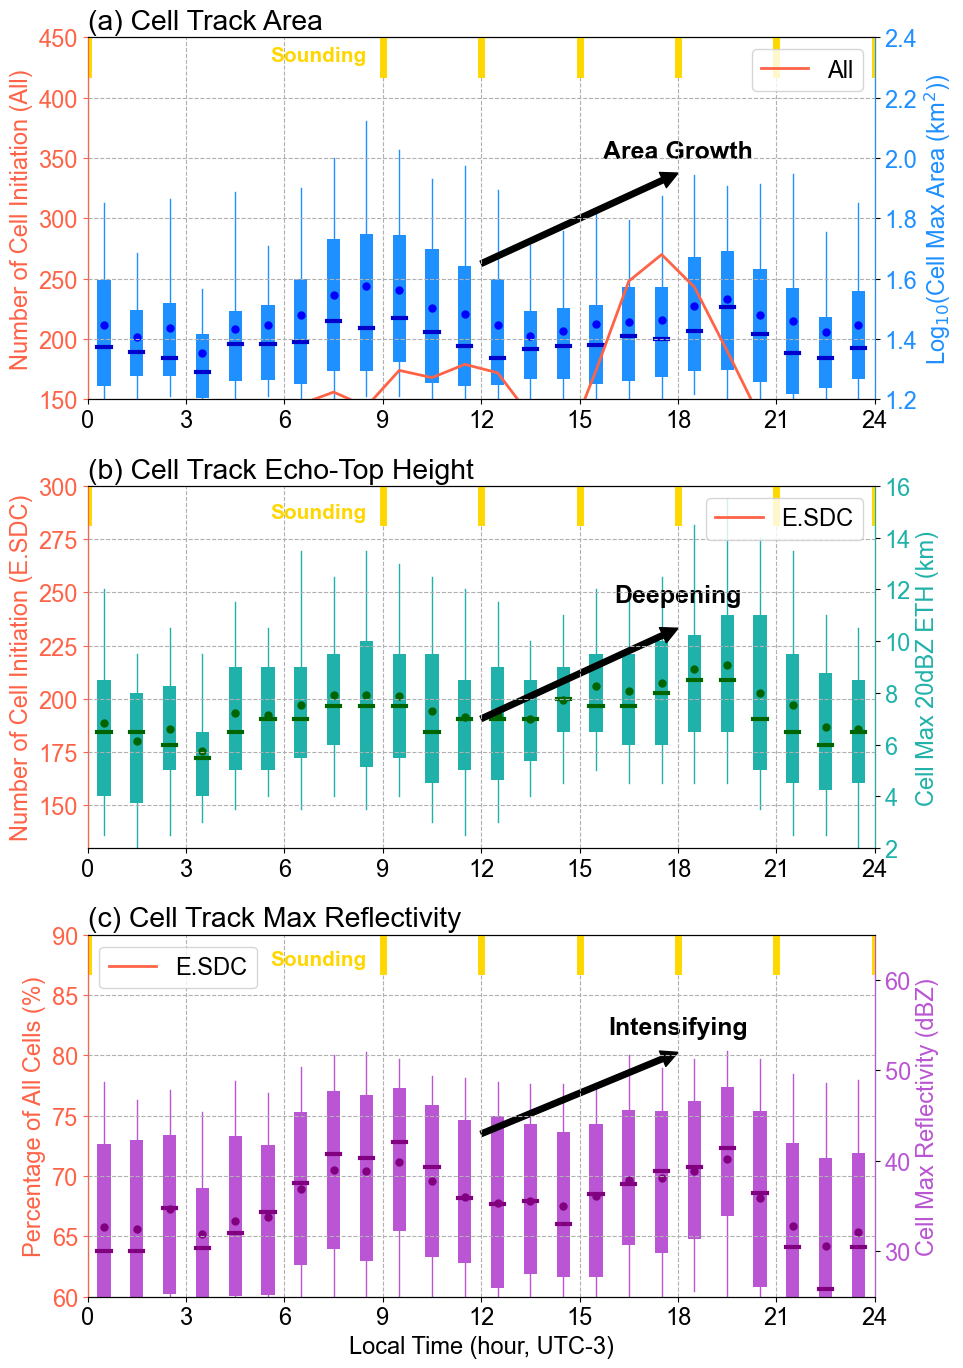

In [13]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'
fig, axes = plt.subplots(3, 1, figsize=[10,14], dpi=100)
sonde_times = [0,9,12,15,18,21,24]

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
ax1 = axes[0]
ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Area', loc='left')
ax1.set_ylabel('Number of Cell Initiation (All)')
ax1.set_ylim(150, 450)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('tomato')
ax1.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(8.5, 430, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_area_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Log$_{10}$(Cell Max Area (km$^2$))', color='dodgerblue')
ax1b.set_ylim(1.2, 2.4)
ax1b.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax1b
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax1b
ax1.spines['left'].set_color('tomato')
ax1.spines['right'].set_color('dodgerblue')
# Annotate
ax1b.annotate("", xy=(18, 1.95), xytext=(12, 1.65), arrowprops=dict(facecolor='black'))
ax1b.text(18, 2, 'Area Growth', ha='center', fontsize=18, fontweight='bold')

#-----------------------------------------------
ax2 = axes[1]
ax2.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, label='E.SDC')
ax2.legend(loc='upper right', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track Echo-Top Height', loc='left')
ax2.set_ylabel('Number of Cell Initiation (E.SDC)')
# ax2.set_xlabel('Local Time (hour, UTC-3)')
ax2.set_ylim(130, 300)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('tomato')
ax2.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(8.5, 285, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
barcolor = 'lightseagreen'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax2b = ax2.twinx()
bp1 = ax2b.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max 20dBZ ETH (km)', color=barcolor)
ax2b.set_ylim(2, 16)
ax2b.tick_params(axis='y', labelcolor=barcolor)
ax2.set_zorder(2)  # default zorder is 0 for ax2 and ax2b
ax2.patch.set_visible(False)  # prevents ax2 from hiding ax2b
ax2.spines['left'].set_color('tomato')
ax2.spines['right'].set_color(barcolor)
# Annotate
ax2b.annotate("", xy=(18, 10.5), xytext=(12, 7), arrowprops=dict(facecolor='black'))
ax2b.text(18, 11.5, 'Deepening', ha='center', fontsize=18, fontweight='bold')

#-----------------------------------------------
ax3 = axes[2]
ax3.plot(hour_binv, hist_starthour_eSDC_LT_frac, color='tomato', lw=2, label='E.SDC')
ax3.legend(loc='upper left', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Cell Track Max Reflectivity', loc='left')
ax3.set_ylabel('Percentage of All Cells (%)')
ax3.set_xlabel('Local Time (hour, UTC-3)')
ax3.set_ylim(60, 90)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
# ax3.spines['left'].set_color('tomato')
ax3.yaxis.label.set_color('tomato')
ax3.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(8.5, 87.5, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='purple')
meanpointprops_ = dict(marker='o', markeredgecolor='purple', markerfacecolor='purple', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax3b = ax3.twinx()
bp1 = ax3b.boxplot(cell_maxdbz_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max Reflectivity (dBZ)', color=barcolor)
ax3b.set_ylim(25, 65)
ax3b.tick_params(axis='y', labelcolor=barcolor)

# Annotate
ax3b.annotate("", xy=(18, 52), xytext=(12, 43), arrowprops=dict(facecolor='black'))
ax3b.text(18, 54, 'Intensifying', ha='center', fontsize=18, fontweight='bold')

ax3.set_zorder(2)  # default zorder is 0 for ax3 and ax3b
ax3.patch.set_visible(False)  # prevents ax3 from hiding ax3b
ax3.spines['left'].set_color('tomato')
ax3.spines['right'].set_color(barcolor)

fig.tight_layout()
# figname = f'{figdir}celltrack_diurnal_startendtime_maxarea_max20dbzETH_maxdbz_boxplot.png'
# fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)

## Calculate cell lifetime distribution

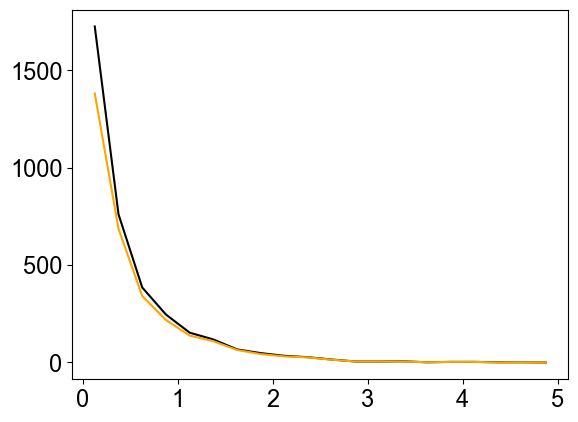

In [14]:
bins_lifetime = np.arange(21)*0.25
bins_lifetime_c = bins_lifetime[:-1] + np.diff(bins_lifetime)/2
hist_lifetime_all, bins = np.histogram(lifetime, bins=bins_lifetime, range=(0,5), density=False)
hist_lifetime_nonmerge, bins = np.histogram(lifetime.isel(tracks=nonmerge), bins=bins_lifetime, range=(0,5), density=False)
plt.plot(bins_lifetime_c, hist_lifetime_all, color='k')
plt.plot(bins_lifetime_c, hist_lifetime_nonmerge, color='orange')

In [15]:
lifetime_nomerge = lifetime.isel(tracks=nonmerge, drop=True)
ncells_nomerge = lifetime_nomerge.count().values
ncells_nomerge_gt30min = np.count_nonzero(lifetime_nomerge > 0.5)
ncells_nomerge_ge1hour = np.count_nonzero(lifetime_nomerge >= 1.0)
frac_nomerge_gt30min = 100 * ncells_nomerge_gt30min / ncells_nomerge
frac_nomerge_ge1hour = 100 * ncells_nomerge_ge1hour / ncells_nomerge
print(f'All non-merge cells: {ncells_nomerge}')
print(f'Non-merge cells > 30 min: {ncells_nomerge_gt30min}')
print(f'Non-merge cells >= 1 hour: {ncells_nomerge_ge1hour}')
print(f'Fraction of cells (> 30 min): {frac_nomerge_gt30min}%')
print(f'Fraction of cells (>= 1 hour): {frac_nomerge_ge1hour}%')

All non-merge cells: 3076
Non-merge cells > 30 min: 1009
Non-merge cells >= 1 hour: 450
Fraction of cells (> 30 min): 32.802340702210664%
Fraction of cells (>= 1 hour): 14.629388816644994%


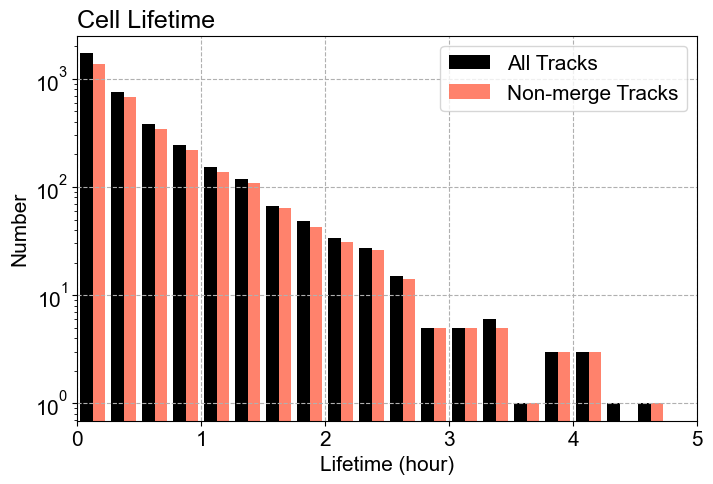

In [16]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

ax1.set_xlabel('Lifetime (hour)')
ax1.set_ylabel('Number')
b1 = ax1.bar(bins_lifetime_c-0.05, hist_lifetime_all, width=0.1, color='k', label='All Tracks')
b2 = ax1.bar(bins_lifetime_c+0.05, hist_lifetime_nonmerge, width=0.1, color='tomato', alpha=0.8, label='Non-merge Tracks')
ax1.legend()
ax1.set_xlim(0, 5)
ax1.set_title('Cell Lifetime', loc='left')
ax1.grid(ls='--')
ax1.set_yscale('log')
# fig.savefig(f'{figdir}celltrack_lifetime_pdf.png', bbox_inches='tight', dpi=300, facecolor='w')

## Function to plot heat maps (1 row x 2 column)

In [17]:
def plot_2heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, titles, figname, eSDC=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [20,40,60,80,100]

    ax1 = axes[0]
    Zm = np.ma.masked_where(dataarr[0] == 0, dataarr[0])
    cmap = plt.get_cmap(cmaps[0])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
    p1 = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p1, ax=ax1, label=cblabels[0])
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(titles[0], loc='left')
    ax1.set_xlim(np.min(lonarr), np.max(lonarr))
    ax1.set_ylim(np.min(latarr), np.max(latarr))
    ax1.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
    ax1.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
    ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax1.plot(radar_lon, radar_lat, **marker_style)
    ax1.grid(ls='--')
    if eSDC is not None:
        ax1.axvline(x=eSDC, color='magenta', lw=2)

    ax2 = axes[1]
    Zm = np.ma.masked_where(dataarr[1] == 0, dataarr[1])
    cmap = plt.get_cmap(cmaps[1])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[1], ncolors=cmap.N)
    p2 = ax2.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p2, ax=ax2, label=cblabels[1])
    ax2.set_xlabel('Longitude')
#     ax2.set_ylabel('Latitude')
    ax2.set_title(titles[1], loc='left')
    ax2.set_xlim(np.min(lonarr), np.max(lonarr))
    ax2.set_ylim(np.min(latarr), np.max(latarr))
    ax2.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
    ax2.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
    ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax2.plot(radar_lon, radar_lat, **marker_style)
    ax2.grid(ls='--')
    if eSDC is not None:
        ax2.axvline(x=eSDC, color='magenta', lw=2)

    fig.tight_layout()
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

## Find all cell track min/max lat/lon

In [18]:
buffer = 0.05
minlon, maxlon = np.nanmin([start_lon.values, end_lon])-buffer, np.nanmax([start_lon.values, end_lon])+buffer
minlat, maxlat = np.nanmin([start_lat.values, end_lat])-buffer, np.nanmax([start_lat.values, end_lat])+buffer
print(minlon, maxlon, minlat, maxlat)

-96.26659088134765 -93.88899536132813 28.43370361328125 30.50535469055176


## Make a Cartesian grid to count the cells

In [19]:
bins = [24, 24]
ranges = [[minlon+buffer,maxlon-buffer], [minlat+buffer,maxlat-buffer]]

hist2d_startloc, xbins, ybins = np.histogram2d(start_lon.values, start_lat.values, bins=bins, range=ranges)
hist2d_endloc, xbins, ybins = np.histogram2d(end_lon, end_lat, bins=bins, range=ranges)

hist2d_startloc = hist2d_startloc.transpose()
hist2d_endloc = hist2d_endloc.transpose()

In [20]:
hist2d_startloc_nonsplit, xbins, ybins = np.histogram2d(start_lon.values[nonsplit_in], start_lat.values[nonsplit_in], bins=bins, range=ranges)
hist2d_endloc_nonmerge, xbins, ybins = np.histogram2d(end_lon[nonmerge_in], end_lat[nonmerge_in], bins=bins, range=ranges)

hist2d_startloc_nonsplit = hist2d_startloc_nonsplit.transpose()
hist2d_endloc_nonmerge = hist2d_endloc_nonmerge.transpose()

In [21]:
hist2d_startloc_split, xbins, ybins = np.histogram2d(start_lon.values[split], start_lat.values[split], bins=bins, range=ranges)
hist2d_endloc_merge, xbins, ybins = np.histogram2d(end_lon[merge], end_lat[merge], bins=bins, range=ranges)

hist2d_startloc_split = hist2d_startloc_split.transpose()
hist2d_endloc_merge = hist2d_endloc_merge.transpose()

In [22]:
end_lon_eSDC = end_lon[np.where(start_lon > lon_SDC)]
end_lat_eSDC = end_lat[np.where(start_lon > lon_SDC)]
hist2d_endloc_eSDC, xbins, ybins = np.histogram2d(end_lon_eSDC, end_lat_eSDC, bins=bins, range=ranges)
hist2d_endloc_eSDC = hist2d_endloc_eSDC.transpose()

end_lon_wSDC = end_lon[np.where(start_lon <= lon_SDC)]
end_lat_wSDC = end_lat[np.where(start_lon <= lon_SDC)]
hist2d_endloc_wSDC, xbins, ybins = np.histogram2d(end_lon_wSDC, end_lat_wSDC, bins=bins, range=ranges)
hist2d_endloc_wSDC = hist2d_endloc_wSDC.transpose()

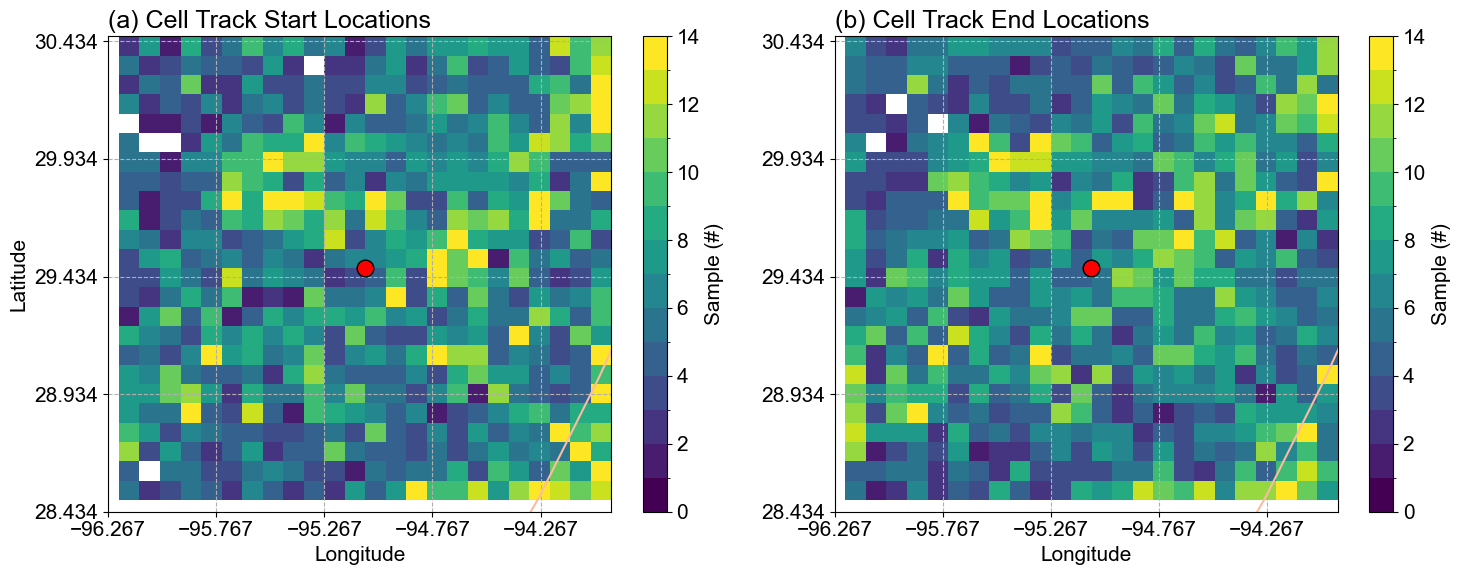

In [23]:
dataarr = [hist2d_startloc, hist2d_endloc]
levels = [np.arange(0, 14.1, 1), np.arange(0, 14.1, 1)]
cmap = ['viridis', 'viridis']
cmap_topo = 'Reds'
titles = ['(a) Cell Track Start Locations', '(b) Cell Track End Locations']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_startend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)


In [24]:
# dataarr = [hist2d_endloc_eSDC, hist2d_endloc_wSDC]
# levels = [np.arange(0, 16, 1), np.arange(0, 16, 1)]
# cmap = ['viridis', 'viridis']
# cmap_topo = 'Reds'
# titles = ['(a) Cell Track End Locations (E.SDC)', '(b) Cell Track End Locations (W.SDC)']
# cblabels = ['Sample (#)', 'Sample (#)']
# figname = f'{figdir}celltrack_end_loc_eSDC_wSDC_0.1.png'
# fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname, eSDC=lon_SDC)

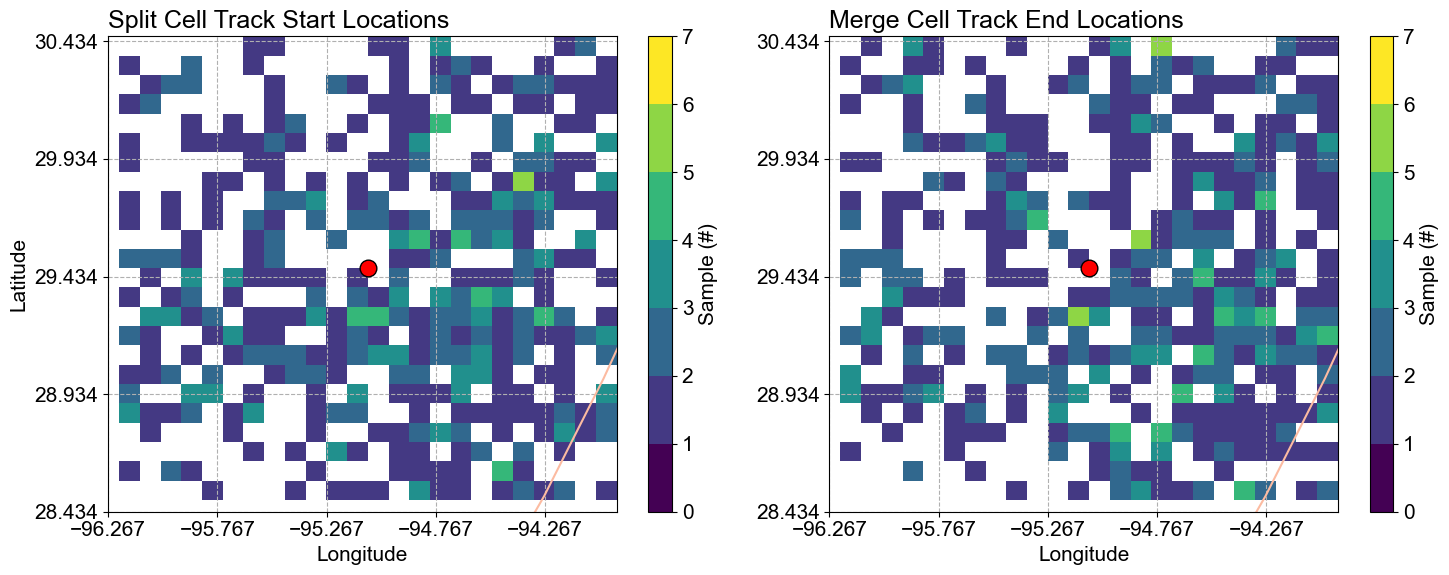

In [25]:
dataarr = [hist2d_startloc_split, hist2d_endloc_merge]
levels = [np.arange(0, 8, 1), np.arange(0, 8, 1)]
cmap = ['viridis','viridis']
cmap_topo = 'Reds'
titles = ['Split Cell Track Start Locations', 'Merge Cell Track End Locations']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_splitstart_mergeend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)

## Separate tracks by start hour and count by locations

In [26]:
shour_nonsplit = start_hour[nonsplit]
start_lon_nonsplit = start_lon.values[nonsplit]
start_lat_nonsplit = start_lat.values[nonsplit]

ehour_nonmerge = end_hour[nonmerge]
end_lon_nonmerge = end_lon[nonmerge]
end_lat_nonmerge = end_lat[nonmerge]

# Get track start hours [UTC]
mask0 = np.logical_and(shour_nonsplit >= 0, shour_nonsplit < 3)
mask3 = np.logical_and(shour_nonsplit >= 3, shour_nonsplit < 6)
mask6 = np.logical_and(shour_nonsplit >= 6, shour_nonsplit < 9)
mask9 = np.logical_and(shour_nonsplit >= 9, shour_nonsplit < 12)
mask12 = np.logical_and(shour_nonsplit >= 12, shour_nonsplit < 15)
mask15 = np.logical_and(shour_nonsplit >= 15, shour_nonsplit < 18)
mask18 = np.logical_and(shour_nonsplit >= 18, shour_nonsplit < 21)
mask21 = np.logical_and(shour_nonsplit >= 21, shour_nonsplit < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_nonsplit_hr0, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask0], start_lon_nonsplit[mask0], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr3, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask3], start_lon_nonsplit[mask3], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr6, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask6], start_lon_nonsplit[mask6], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr9, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask9], start_lon_nonsplit[mask9], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr12, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask12], start_lon_nonsplit[mask12], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr15, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask15], start_lon_nonsplit[mask15], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr18, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask18], start_lon_nonsplit[mask18], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr21, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask21], start_lon_nonsplit[mask21], bins=bins, range=ranges)

In [27]:
# Get track start hours [UTC]
mask0 = np.logical_and(start_hour >= 0, start_hour < 3)
mask3 = np.logical_and(start_hour >= 3, start_hour < 6)
mask6 = np.logical_and(start_hour >= 6, start_hour < 9)
mask9 = np.logical_and(start_hour >= 9, start_hour < 12)
mask12 = np.logical_and(start_hour >= 12, start_hour < 15)
mask15 = np.logical_and(start_hour >= 15, start_hour < 18)
mask18 = np.logical_and(start_hour >= 18, start_hour < 21)
mask21 = np.logical_and(start_hour >= 21, start_hour < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_hr0, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask0], start_lon.values[mask0], bins=bins, range=ranges)
hist2d_startloc_hr3, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask3], start_lon.values[mask3], bins=bins, range=ranges)
hist2d_startloc_hr6, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask6], start_lon.values[mask6], bins=bins, range=ranges)
hist2d_startloc_hr9, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask9], start_lon.values[mask9], bins=bins, range=ranges)
hist2d_startloc_hr12, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask12], start_lon.values[mask12], bins=bins, range=ranges)
hist2d_startloc_hr15, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask15], start_lon.values[mask15], bins=bins, range=ranges)
hist2d_startloc_hr18, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask18], start_lon.values[mask18], bins=bins, range=ranges)
hist2d_startloc_hr21, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask21], start_lon.values[mask21], bins=bins, range=ranges)

## Plot cell start location heat map by diurnal timing

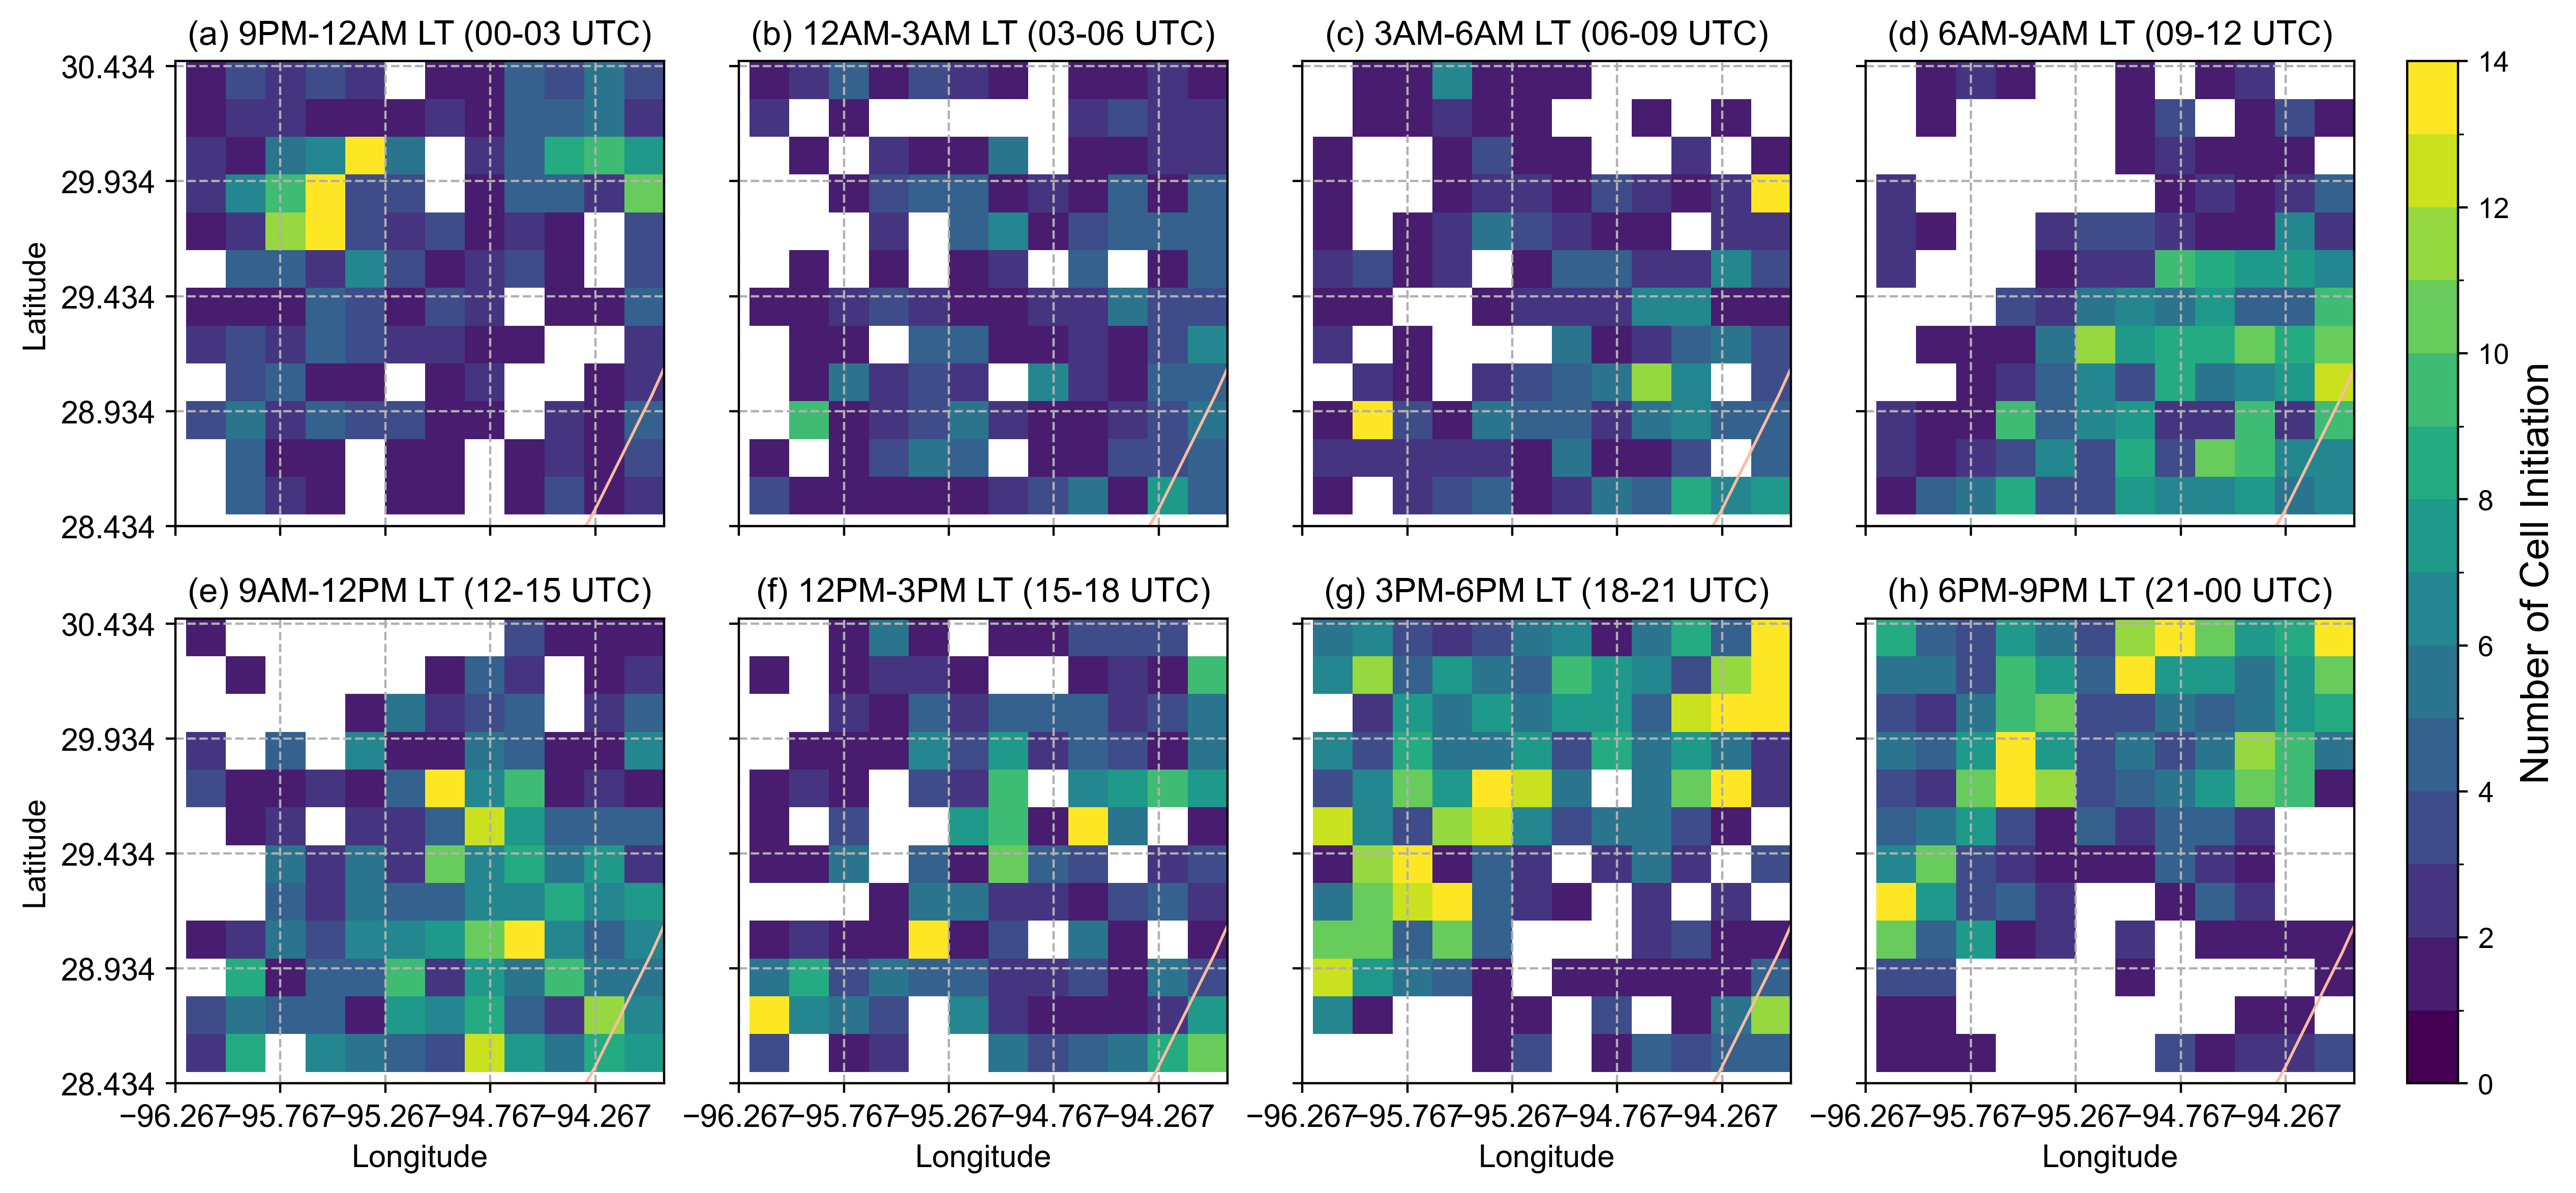

In [28]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Arial'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=400)
   
dataarr = [[hist2d_startloc_hr0, hist2d_startloc_hr3, hist2d_startloc_hr6, hist2d_startloc_hr9],
    [hist2d_startloc_hr12, hist2d_startloc_hr15, hist2d_startloc_hr18, hist2d_startloc_hr21]
           ]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 14.1, 1)
cbticks = np.arange(0, 14.1, 2)
titles = [['(a) 9PM-12AM LT (00-03 UTC)', '(b) 12AM-3AM LT (03-06 UTC)', '(c) 3AM-6AM LT (06-09 UTC)', '(d) 6AM-9AM LT (09-12 UTC)'],
          ['(e) 9AM-12PM LT (12-15 UTC)', '(f) 12PM-3PM LT (15-18 UTC)', '(g) 3PM-6PM LT (18-21 UTC)', '(h) 6PM-9PM LT (21-00 UTC)']
          ]
cblabel = 'Number of Cell Initiation'

cmap = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [20,40,60,80,100]
cmap_topo = 'Reds'

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='CENTER', fontsize=12)
        ax1.set_xlim(np.min(lonarr), np.max(lonarr))
        ax1.set_ylim(np.min(latarr), np.max(latarr))
        ax1.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
        ax1.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        #ax1.plot(radar_lon, radar_lat, **marker_style)
        #ax1.text(radar_lon+0.1, radar_lat, 'AMF', fontsize=8, color='red')
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
            if (col == 0):
                # Legend for terrain
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.8), lw=2)]
                # ax1.legend(custom_lines, ['Terrain'], loc='upper right')
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 color for the whole figure
cbar = fig.colorbar(pcm_save[0], ax=axs[:, :], shrink=1, pad=0.02)
cbar.set_ticks(cbticks)
cbar.set_label(label=cblabel, fontsize=14)
cbar.ax.tick_params(labelsize=10)
fig.savefig('No_Cell_Initiations.png', bbox_inches='tight')


# figname = f'{figdir}celltrack_start_loc_diurnal_cycle_0.2deg_2x4.png'
# fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)

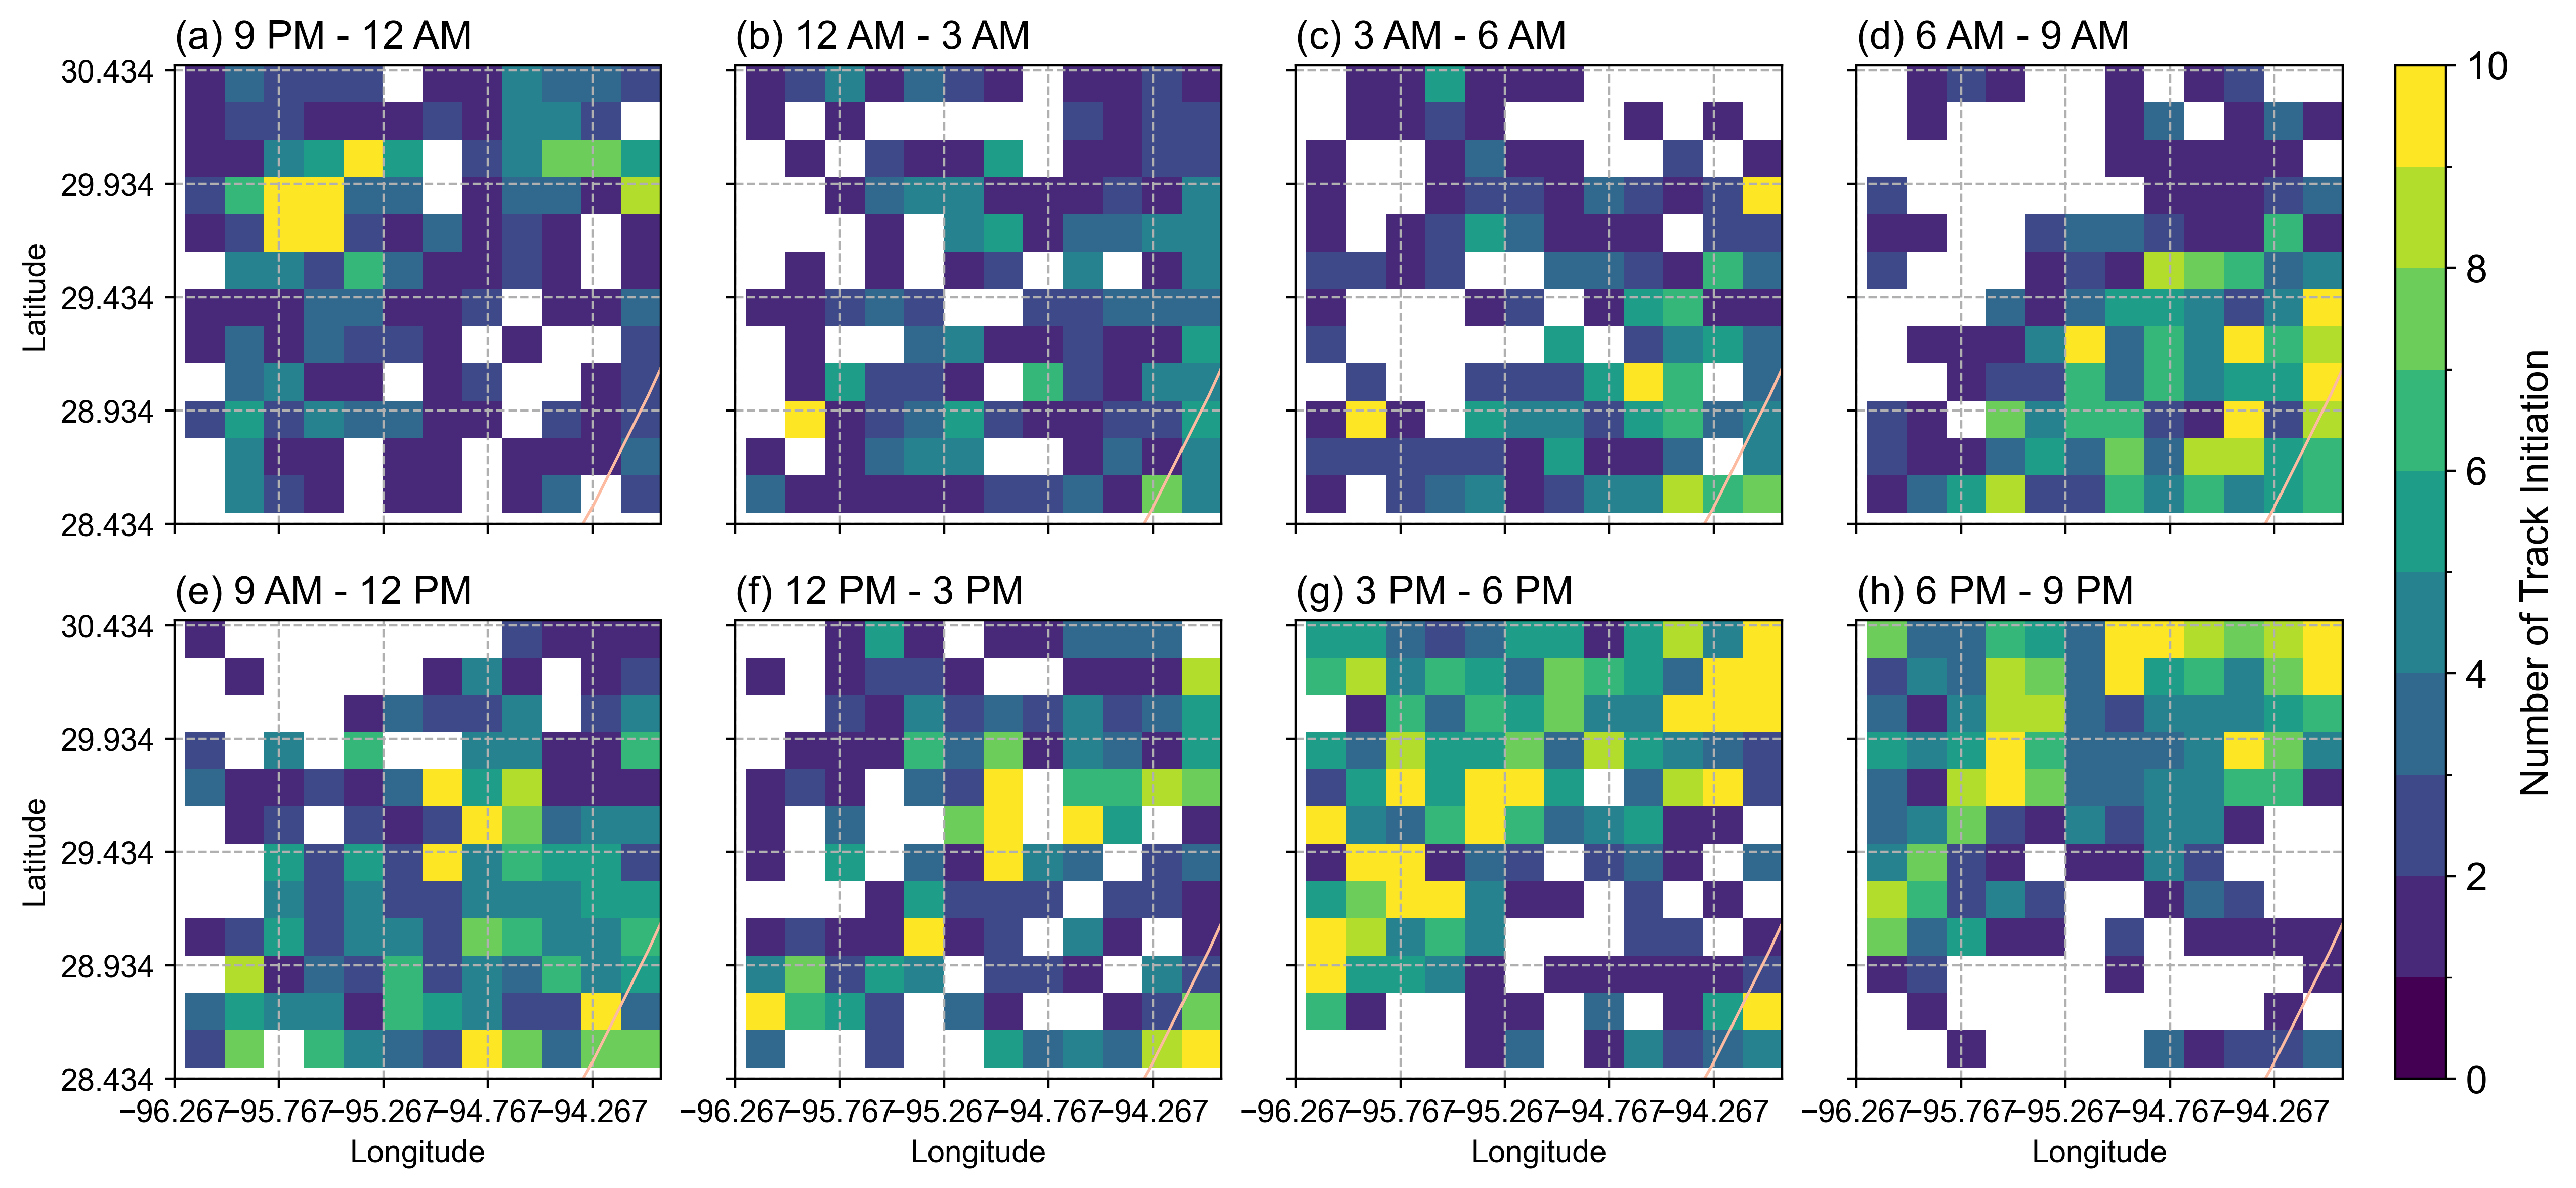

In [29]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Arial'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=400)
   
dataarr = [[hist2d_startloc_nonsplit_hr0, hist2d_startloc_nonsplit_hr3, hist2d_startloc_nonsplit_hr6, hist2d_startloc_nonsplit_hr9],
           [hist2d_startloc_nonsplit_hr12, hist2d_startloc_nonsplit_hr15, hist2d_startloc_nonsplit_hr18, hist2d_startloc_nonsplit_hr21]
           ]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 10.1, 1)
cbticks = np.arange(0, 10.1, 2)
titles = [['(a) 9 PM - 12 AM', '(b) 12 AM - 3 AM', '(c) 3 AM - 6 AM', '(d) 6 AM - 9 AM'],
          ['(e) 9 AM - 12 PM', '(f) 12 PM - 3 PM', '(g) 3 PM - 6 PM', '(h) 6 PM - 9 PM']
          ]
cblabel = 'Number of Track Initiation'

cmap = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [20,40,60,80,100]
cmap_topo = 'Reds'

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='left', fontsize=14)
        ax1.set_xlim(np.min(lonarr), np.max(lonarr))
        ax1.set_ylim(np.min(latarr), np.max(latarr))
        ax1.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
        ax1.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        # ax1.plot(radar_lon, radar_lat, **marker_style)
        #ax1.text(radar_lon+0.1, radar_lat, 'AMF', fontsize=13, color='red')
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
            if (col == 0):
                # Legend for terrain
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.8), lw=2)]
                #ax1.legend(custom_lines, ['Terrain'], loc='upper right')
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 color for the whole figure
cbar = fig.colorbar(pcm_save[0], ax=axs[:, :], shrink=1, pad=0.02)
cbar.set_ticks(cbticks)
cbar.set_label(label=cblabel, fontsize=14)
cbar.ax.tick_params(labelsize=14)
fig.savefig('No_Track_Initiations.png', bbox_inches='tight')

# fig.savefig(f'{figdir}celltrack_nonsplitstart_loc_diurnal_cycle_0.2deg_2x4.png', bbox_inches='tight', dpi=300)

## Calculate mean/max cell statistics by locations

In [30]:
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
hist2d_startloc_02deg, yy, xx = np.histogram2d(start_lat, start_lon, bins=[latbins, lonbins])
hist2d_endloc_02deg, yy, xx = np.histogram2d(end_lat, end_lon, bins=[latbins, lonbins])

Mean_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
pt95_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat = np.array(cell_lon).flatten()
Lat_flat = np.array(cell_lat).flatten()
Area_flat = np.array(cell_area).flatten()
ETH10_flat = np.array(eth10).flatten()
ETH20_flat = np.array(eth20).flatten()
ETH30_flat = np.array(eth30).flatten()
ETH40_flat = np.array(eth40).flatten()
ETH50_flat = np.array(eth50).flatten()
Core_Area_flat = np.array(core_area).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat >= lonbins[i], Lon_flat < lonbins[i]+lonbinsize),
                              Lat_flat >= latbins[j]), Lat_flat < latbins[j]+latbinsize), Area_flat > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Area_heatmap[j,i] = np.nanmean(Area_flat[mask])
            Median_Area_heatmap[j,i] = np.nanmedian(Area_flat[mask])
            Max_Area_heatmap[j,i] = np.nanmax(Area_flat[mask])
            Mean_ETH10_heatmap[j,i] = np.nanmean(ETH10_flat[mask])
            Median_ETH10_heatmap[j,i] = np.nanmedian(ETH10_flat[mask])
            Max_ETH10_heatmap[j,i] = np.nanmax(ETH10_flat[mask])
            Mean_ETH20_heatmap[j,i] = np.nanmean(ETH20_flat[mask])
            Median_ETH20_heatmap[j,i] = np.nanmedian(ETH20_flat[mask])
            Max_ETH20_heatmap[j,i] = np.nanmax(ETH20_flat[mask])
            Mean_ETH30_heatmap[j,i] = np.nanmean(ETH30_flat[mask])
            Median_ETH30_heatmap[j,i] = np.nanmedian(ETH30_flat[mask])
            Max_ETH30_heatmap[j,i] = np.nanmax(ETH30_flat[mask])
            pt95_ETH30_heatmap[j,i] = np.nanpercentile(ETH30_flat[mask], 95)
            Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])
            Mean_Core_Area_heatmap[j,i] = np.nanmean(Core_Area_flat[mask])
            Median_Core_Area_heatmap[j,i] = np.nanmedian(Core_Area_flat[mask])
            Max_Core_Area_heatmap[j,i] = np.nanmax(Core_Area_flat[mask])
            
            Mean_ETH40_heatmap[j,i] = np.nanmean(ETH40_flat[mask])
            Median_ETH40_heatmap[j,i] = np.nanmedian(ETH40_flat[mask])
            Max_ETH40_heatmap[j,i] = np.nanmax(ETH40_flat[mask])
            Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
            Median_ETH50_heatmap[j,i] = np.nanmedian(ETH50_flat[mask])
            Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])

C:\Users\omitu\AppData\Local\Temp\ipykernel_14712\1324778797.py:84: RuntimeWarning: Mean of empty slice
  Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
c:\Users\omitu\anaconda3\envs\metstat\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\omitu\AppData\Local\Temp\ipykernel_14712\1324778797.py:86: RuntimeWarning: All-NaN slice encountered
  Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_14712\1324778797.py:76: RuntimeWarning: Mean of empty slice
  Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_14712\1324778797.py:81: RuntimeWarning: Mean of empty slice
  Mean_ETH40_heatmap[j,i] = np.nanmean(ETH40_flat[mask])
C:\Users\omitu\AppData\Local\Temp\ipykernel_14712\1324778797.py:83: RuntimeWarning: All-NaN slice encountered
  Max_ETH40_heatmap[j,i] = np.n

## Function to plot heatmaps (2 rows x 2 columns)

In [31]:
def plot_4heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname, eSDC=None):
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Arial'
    fig, axes = plt.subplots(2, 2, figsize=(12.5,10), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]

    for row in range(2):
        for col in range(2):
            ax = axes[row,col]
            Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
            cmap = plt.get_cmap(cmaps[row][col])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            p1 = ax.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap, shading='auto')
            cb = plt.colorbar(p1, ax=ax, label=cblabels[row][col], ticks=cbticks[row][col])
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlim(np.min(lonarr), np.max(lonarr))
            ax.set_ylim(np.min(latarr), np.max(latarr))
            ax.set_xticks(np.arange(-96.26659088134765, -93.88899536132813, 0.5))
            ax.set_yticks(np.arange(28.43370361328125, 30.50535469055176, 0.5))
            ax.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[row][col], linewidths=1.5)
            #ax.plot(radar_lon, radar_lat, **marker_style)
            #ax.text(0.5, 1.05, 'AMF', fontsize=15)
            ax.grid(ls='--')
            if eSDC is not None:
                ax.axvline(x=eSDC, color='magenta', lw=2)

            # Legend for terrain
            custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo[row][col])(0.8), lw=2)]
            # ax.legend(custom_lines, ['Terrain'], loc='upper right')  # Add terrain legend

    fig.tight_layout()
    # fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

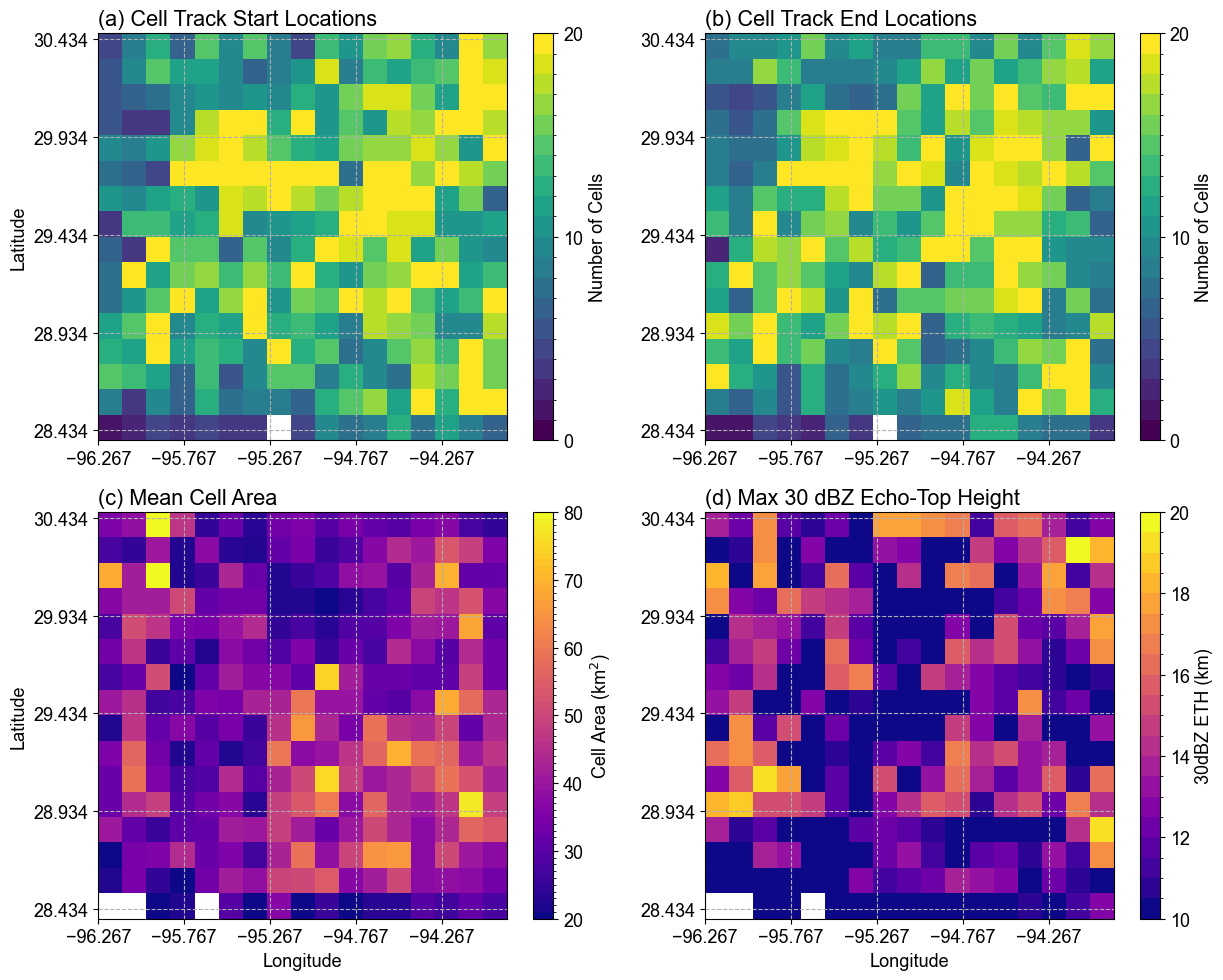

In [32]:
dataarr = [[hist2d_startloc_02deg, hist2d_endloc_02deg], [Mean_Area_heatmap, Max_ETH30_heatmap]]
levels = [[np.arange(0, 20.1, 1), np.arange(0, 20.1, 1)], [np.arange(20, 80.1, 1), np.arange(10, 20.1, 0.5)]]
cbticks = [[np.arange(0, 20.1, 10), np.arange(0, 20.1, 10)], [np.arange(20, 80.1, 10), np.arange(10, 20.1, 2)]]
cmap = [['viridis', 'viridis'], ['plasma','plasma']]
cmap_topo = [['Reds', 'Reds'], ['Greens', 'Greens']]
titles = [['(a) Cell Track Start Locations', '(b) Cell Track End Locations'], 
          ['(c) Mean Cell Area', '(d) Max 30 dBZ Echo-Top Height'],]
cblabels = [['Number of Cells', 'Number of Cells'], ['Cell Area (km$^2$)', '30dBZ ETH (km)']]
xlabels = [['',''], ['Longitude','Longitude']]
ylabels = [['Latitude',''],['Latitude','']]
figname = f'{figdir}celltrack_StartEndloc_MeanCellArea_Max30dBZETH_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname)

# Variability of Updraft Intensity: Explore the variability in updraft intensity within convective cells of different sizes. Determine if larger convective cells tend to have consistently stronger updrafts throughout their core area or if there is significant spatial variability in updraft intensity.

### First, we plot the spatial distribution of core area based on different cell sizes. I have assumed that the core area is a proxy for strong updrafts.
### I defined the cell sizes based on quantiles: 
### <= 25%: Very Small Cells; 25%-50%: Small Cells; 50%-75%: Large Cells; >75%: Large Cells

In [33]:
# Calculate the quartiles of the 'cell_area' data
q25 = cell_area.quantile(0.25).values
q50 = cell_area.quantile(0.50).values
q75 = cell_area.quantile(0.75).values

# Create masks that select the indices where 'cell_area' falls into the specific quartile ranges
mask_q1 = cell_area <= q25
mask_q2 = (cell_area > q25) & (cell_area <= q50)
mask_q3 = (cell_area > q50) & (cell_area <= q75)
mask_q4 = cell_area > q75

# Select the values from 'core_area' at these indices
core_area_q1 = core_area.where(mask_q1, drop=True)
core_area_q2 = core_area.where(mask_q2, drop=True)
core_area_q3 = core_area.where(mask_q3, drop=True)
core_area_q4 = core_area.where(mask_q4, drop=True)

cell_lon_q1 = cell_lon.where(mask_q1, drop=True)
cell_lat_q1 = cell_lat.where(mask_q1, drop=True)
cell_lon_q2 = cell_lon.where(mask_q2, drop=True)
cell_lat_q2 = cell_lat.where(mask_q2, drop=True)
cell_lon_q3 = cell_lon.where(mask_q3, drop=True)
cell_lat_q3 = cell_lat.where(mask_q3, drop=True)
cell_lon_q4 = cell_lon.where(mask_q4, drop=True)
cell_lat_q4 = cell_lat.where(mask_q4, drop=True)


In [34]:
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q1 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q1 = np.array(cell_lon_q1).flatten()
Lat_flat_q1 = np.array(cell_lat_q1).flatten()
Core_Area_flat_q1 = np.array(core_area_q1).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q1 >= lonbins[i], Lon_flat_q1 < lonbins[i]+lonbinsize),
                              Lat_flat_q1 >= latbins[j]), Lat_flat_q1 < latbins[j]+latbinsize), Core_Area_flat_q1 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q1[j,i] = np.nanmean(Core_Area_flat_q1[mask])
            Median_Core_Area_heatmap_q1[j,i] = np.nanmedian(Core_Area_flat_q1[mask])
            Max_Core_Area_heatmap_q1[j,i] = np.nanmax(Core_Area_flat_q1[mask])
            

# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q2 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q2 = np.array(cell_lon_q2).flatten()
Lat_flat_q2 = np.array(cell_lat_q2).flatten()
Core_Area_flat_q2 = np.array(core_area_q2).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q2 >= lonbins[i], Lon_flat_q2 < lonbins[i]+lonbinsize),
                              Lat_flat_q2 >= latbins[j]), Lat_flat_q2 < latbins[j]+latbinsize), Core_Area_flat_q2 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q2[j,i] = np.nanmean(Core_Area_flat_q2[mask])
            Median_Core_Area_heatmap_q2[j,i] = np.nanmedian(Core_Area_flat_q2[mask])
            Max_Core_Area_heatmap_q2[j,i] = np.nanmax(Core_Area_flat_q2[mask])

# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q3 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q3 = np.array(cell_lon_q3).flatten()
Lat_flat_q3 = np.array(cell_lat_q3).flatten()
Core_Area_flat_q3 = np.array(core_area_q3).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q3 >= lonbins[i], Lon_flat_q3 < lonbins[i]+lonbinsize),
                              Lat_flat_q3 >= latbins[j]), Lat_flat_q3 < latbins[j]+latbinsize), Core_Area_flat_q3 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q3[j,i] = np.nanmean(Core_Area_flat_q3[mask])
            Median_Core_Area_heatmap_q3[j,i] = np.nanmedian(Core_Area_flat_q3[mask])
            Max_Core_Area_heatmap_q3[j,i] = np.nanmax(Core_Area_flat_q3[mask])
            
# heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
lon_nbin = 17
lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13

lonbins = np.arange(lon_nbin+1)*lonbinsize + minlon
latbins = np.arange(lat_nbin+1)*latbinsize + minlat - 0.05

# Count cell start/end location heatmap with the Cartesian grid
Mean_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Core_Area_heatmap_q4 = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat_q4 = np.array(cell_lon_q4).flatten()
Lat_flat_q4 = np.array(cell_lat_q4).flatten()
Core_Area_flat_q4 = np.array(core_area_q4).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat_q4 >= lonbins[i], Lon_flat_q4 < lonbins[i]+lonbinsize),
                              Lat_flat_q4 >= latbins[j]), Lat_flat_q4 < latbins[j]+latbinsize), Core_Area_flat_q4 > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Core_Area_heatmap_q4[j,i] = np.nanmean(Core_Area_flat_q4[mask])
            Median_Core_Area_heatmap_q4[j,i] = np.nanmedian(Core_Area_flat_q4[mask])
            Max_Core_Area_heatmap_q4[j,i] = np.nanmax(Core_Area_flat_q4[mask])
                           

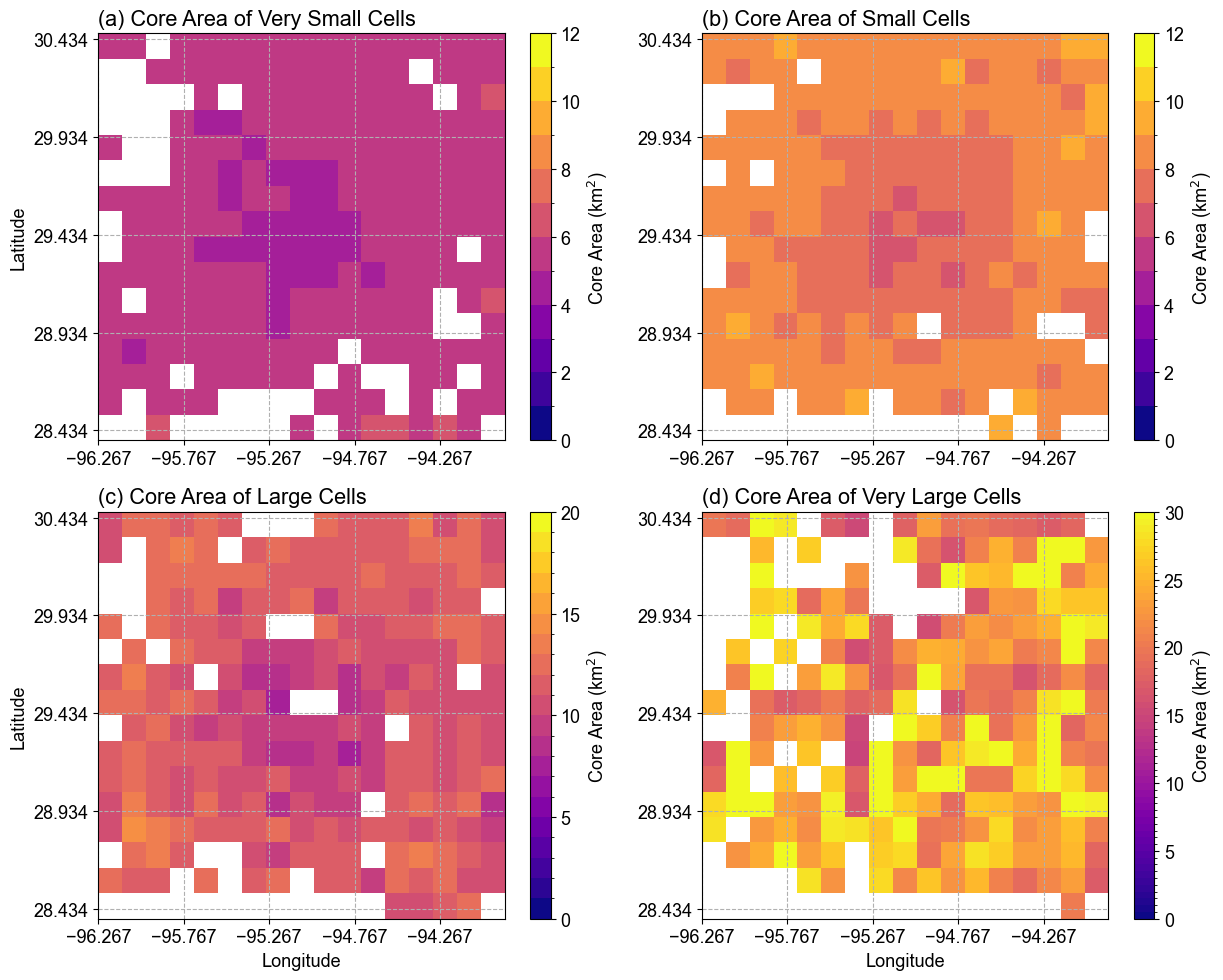

In [35]:
dataarr = [[Mean_Core_Area_heatmap_q1, Mean_Core_Area_heatmap_q2], [Mean_Core_Area_heatmap_q3, Mean_Core_Area_heatmap_q4]]
levels = [[np.arange(0, 12.1, 1), np.arange(0, 12.1, 1)], [np.arange(0, 20.1, 1), np.arange(0, 30.1, 0.5)]]
cbticks = [[np.arange(0, 12.1, 2), np.arange(0, 15.1, 2)], [np.arange(0, 20.1, 5), np.arange(0, 30.1, 5)]]
cmap = [['plasma', 'plasma'], ['plasma','plasma']]
cmap_topo = [['Reds', 'Reds'], ['Greens', 'Greens']]
titles = [['(a) Core Area of Very Small Cells', '(b) Core Area of Small Cells'], 
          ['(c) Core Area of Large Cells', '(d) Core Area of Very Large Cells'],]
cblabels = [['Core Area (km$^2$)', 'Core Area (km$^2$)'], ['Core Area (km$^2$)', 'Core Area (km$^2$)']]
xlabels = [['',''], ['Longitude','Longitude']]
ylabels = [['Latitude',''],['Latitude','']]
figname = f'{figdir}celltrack_StartEndloc_MeanCellArea_Max30dBZETH_0.2deg.png'

fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname)

### Now we perform statistical analysis to quantify the variability in updraft intensity within different size categories of convective cells.
### We compare average updraft intensity values among different size categories using appropriate statistical tests (e.g., t-tests, ANOVA) to determine if there are significant differences.

In [36]:
levels = [0.1,0.2,0.4,0.6,0.8,1]
legend_labels = ['May', 'June', 'July']

In [37]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, figname, 
                   legend_loc='lower right', legend_labels=None):
    mpl.rcParams['font.family'] = 'Arial'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    # legend_labels = ['OBS', f'{model_name[name_map["m1"]]}']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    #g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import copy

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname,
                   legend_loc='lower right', legend_labels=None):
    mpl.rcParams['font.family'] = 'Arial'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Arial', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')
    # g.savefig(figname, dpi=300, facecolor='w')
    return g

# Define levels and legend labels
levels = [0.1,0.2,0.4,0.6,0.8,1]
legend_labels = ['May', 'June', 'July']

cell_area = stats['cell_area']
core_area = stats['core_area']

# Applying log transformation to both x and y
x_obs, y_obs = np.log10((cell_area.values).flatten()), np.log10((core_area.values).flatten())
x_m1, y_m1 = np.log10((cell_area.values).flatten()), np.log10((core_area.values).flatten())

# Calculate the minimum and maximum values of x and y
x_min, x_max = 0.5, np.nanmax(x_obs)
y_min, y_max = 0.5, np.nanmax(y_obs)

# Update the x and y limits
xlim = (x_min, x_max)
ylim = (y_min, y_max)

# Update xlabel and ylabel
xlabel = 'Log$_{10}$(Convective Cell Lifetime [hour])'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'

# Add annotation text and figure name
annotate_text = 'Your text here'
figname = 'Your figure name here'

# Run the plot function
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_labels=legend_labels)
plt.show()


NameError: name 'stats' is not defined

### Now we find the spatial relationship between updraft intensity and precipitation using spatial correlation map